In [1]:
############
# PACKAGES #
############

%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
theano.config.exception_verbosity='high'
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import gzip
import os
import sys
import timeit

import cartpole_lib as cp

import nnet_lib as nnet


In [16]:
#################
# GENERATE DATA #
#################

dt, eps = 0.1, 0.1
Q = np.eye(6)
R = np.eye(1)

xref1 = np.array([0,np.pi,0,0,10,1])
uref = 0.
A1, B1, c1 = cp.linearize_cartpole_ext(xref1, uref, dt, eps)
K1, P1, Quu1 = cp.lqr_infinite_horizon(A1, B1, Q, R)

x1 = np.array([0, np.pi - np.pi/4, 0, 0, 10, 1])
x2 = np.array([0, np.pi + np.pi/4, 0, 0, 10, 1])

tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data([x1, x2], [K1, K1], [Quu1, Quu1], 
                                                         num_traj=20, traj_size=500)

In [18]:
####################
# TRAIN BASIC NNET #
####################

input1, policy1, tr_loss1, val_loss1, test_loss1 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=15, # Nnet parameters
    learning_rule='adagrad', learning_rate=1.0, L1_reg=0.0, L2_reg=0.00001, batch_size=50, rho=0.9, #SGD parameters
    n_epochs=100, print_interval=5, random_order=True # Training parameters
)

... building the model
... training
epoch 5, minibatch 400/400, validation error 150.381296, test error of best model 150.493336
epoch 10, minibatch 400/400, validation error 59.205403, test error of best model 66.763382
epoch 15, minibatch 400/400, validation error 24.248705, test error of best model 38.578892
epoch 20, minibatch 400/400, validation error 12.983861, test error of best model 31.423591
epoch 25, minibatch 400/400, validation error 10.881188, test error of best model 30.345636
epoch 30, minibatch 400/400, validation error 9.785442, test error of best model 32.213916
epoch 35, minibatch 400/400, validation error 8.764191, test error of best model 32.031076
epoch 40, minibatch 400/400, validation error 8.009929, test error of best model 31.784991
epoch 45, minibatch 400/400, validation error 7.576501, test error of best model 31.676902
epoch 50, minibatch 400/400, validation error 7.313695, test error of best model 31.712779
epoch 55, minibatch 400/400, validation error 7.

Final position for starting position x1
[ -8.15003106e-01   3.14159072e+00  -8.87942404e-06   7.99361097e-07
   1.00000000e+01   1.00000000e+00]
Final position for starting position x2
[ -8.14746114e-01   3.14159473e+00   2.60782462e-05  -7.08281459e-07
   1.00000000e+01   1.00000000e+00]


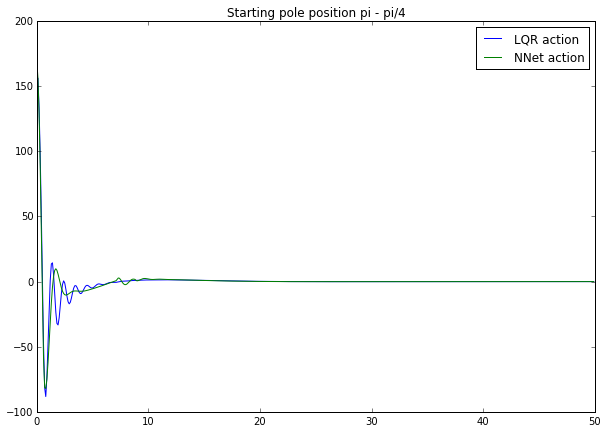

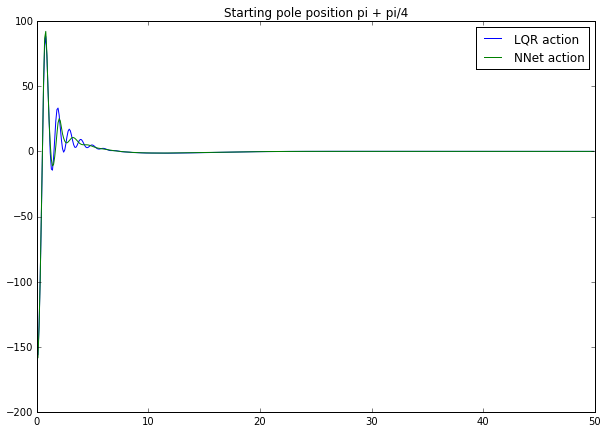

In [29]:
####################
# TEST NNET POLICY #
####################

feed_forward = theano.function(
    inputs=[input1],
    outputs=policy1.output)

x_ref = np.array([0, np.pi, 0, 0, 10, 1])

# First starting position
x_sim1 = np.zeros([6,500])
x_sim1[:,0] = x1

u_sim1 = np.zeros([500,])
u_sim1[0] = feed_forward(x_sim1[:,0].reshape([1,6]))

for t in range(499):
    x_sim1[:,t+1] = cp.sim_cartpole_ext(x_sim1[:,t], u_sim1[t], dt)
    u_sim1[t+1] = feed_forward(x_sim1[:,t+1].reshape([1,6]))

x_lqr1 = np.zeros([6,500])
x_lqr1[:,0] = x1

u_lqr1 = np.zeros([500,])
u_lqr1[0] = np.dot(K1, x_lqr[:,0] - x_ref)
for t in range(499):
    x_lqr1[:,t+1] = cp.sim_cartpole_ext(x_lqr1[:,t], u_lqr1[t], dt)
    u_lqr1[t+1] = np.dot(K1, x_lqr1[:,t] - x_ref)

# Second starting position
x_sim2 = np.zeros([6,500])
x_sim2[:,0] = x2

u_sim2 = np.zeros([500,])
u_sim2[0] = feed_forward(x_sim2[:,0].reshape([1,6]))

for t in range(499):
    x_sim2[:,t+1] = cp.sim_cartpole_ext(x_sim2[:,t], u_sim2[t], dt)
    u_sim2[t+1] = feed_forward(x_sim2[:,t+1].reshape([1,6]))

x_lqr2 = np.zeros([6,500])
x_lqr2[:,0] = x2

u_lqr2 = np.zeros([500,])
u_lqr2[0] = np.dot(K1, x_lqr2[:,0] - x_ref)
for t in range(499):
    x_lqr2[:,t+1] = cp.sim_cartpole_ext(x_lqr2[:,t], u_lqr2[t], dt)
    u_lqr2[t+1] = np.dot(K1, x_lqr2[:,t] - x_ref)
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr1.flatten(), label="LQR action")
plt.plot(tt, u_sim1.flatten(), label="NNet action")
plt.title("Starting pole position pi - pi/4")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr2.flatten(), label="LQR action")
plt.plot(tt, u_sim2.flatten(), label="NNet action")
plt.title("Starting pole position pi + pi/4")
plt.legend()

print "Final position for starting position x1"
print x_sim1[:,-1]
print "Final position for starting position x2"
print x_sim2[:,-1]